### Fitting Nonlinear Dispersion using simulations of the IOTA 8-2 (low tune) lattice

This notebook examines the presence of nonlinear dispersion in the (Tier 1) IOTA lattice by simulating an array of particles with varying energy spread and evaluating their perturbed trajectories.

**Note**
- This notebook uses an adjusted lattice constructed by Sasha Romanov. It's based on the IOTA 8-2 design but the quads have been changed to reduce the tunes: $\nu_x = 3.8$ and $\nu_y=2.8$

**Actions**
1. Consider an ensemble of particle starting at the origin but with a range of energy offsets (-0.005 to 0.005)
    1. Run a single turn
    2. Look at the new position (in x) of the particle (this should be nonzero in the presence of dispersion)
    3. Plot the x-position as a function of energy offset
    4. Perform a fit and see what order contributions dominate

## Imports

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy import constants
import tables
from mpi4py import MPI

In [3]:
from base_diagnostics import utils
from base_diagnostics import read_bunch
from base_diagnostics import workflow
from base_diagnostics import lfplot
from base_diagnostics import latticework
from base_diagnostics import basic_calcs
from base_diagnostics import pltbunch
from base_diagnostics import elliptic_sp
from base_diagnostics import singleparticle
from base_diagnostics import options
from standard import standard_beam6d
from elliptic import elliptic_beam6d
from semigaussian import semi_gaussian6d

import synergia
import synergia_workflow

## Load options and lattice

In [4]:
#load options for ZC_test
from ZC_test_options import opts

#================== Setting up logger and MPI comunicator ============================
#try:
#if True:
# this is the communicator object that will be used for MPI operations
comm = synergia.utils.Commxx()
myrank = comm.get_rank()
mpisize = comm.get_size()
verbose = opts.verbosity>0

logger = synergia.utils.Logger(0)


if myrank == 0:
    print "my rank is 0"
else:
    print "not rank 0"

my rank is 0


In [5]:
#================== Load the lattice =======================

lattices = {}
dir_66 = '/Users/ncook/radiasoft/ioptics/ioptics/lattices/Iota6-6/'
dir_82 = '/Users/ncook/radiasoft/ioptics/ioptics/lattices/Iota8-2/'

lattices['t1_1IO_66'] = dir_66 + "lattice_1IO_center.madx" #centered t1 6.6 1IO lattice
lattices['t1_1IO_82_uncentered'] = dir_82 + "lattice_1IO.madx" #uncentered tier1 8.2 lattice
lattices['t1_1IO_82'] = dir_82 + "lattice_1IO_center.madx" #this is the new tier1 8.2 (zero current) lattice
lattices['t1_1IO_82_dQ_1'] = dir_82 + "lattice_1IO_dQ_1.madx" #t1 8.2 lattice adjusted for dQ = -0.1
lattices['t1_1IO_82_dQ'] = dir_82 + "lattice_1IO_dQ_2.madx" #t1 8.2 lattice adjusted for dQ = -0.2
lattices['t1_1IO_82_lowtune'] = dir_82 + "lattice_1IO_lowtune_center.madx" #t1 8.2 lattice with reduced tune

lattices['t3_1IO_66'] = dir_66 + "lattice_1IO_nll_center.madx" #centered t3 6.6 1IO lattice
lattices['t3_1IO_82'] = dir_82 + "lattice_1IO_nll_center.madx" #this is the centerted t3 8.2 lattice


#================= Construct a Python dictionary of lattice stuff ==================
lattice_dict = {}

for keys in lattices.keys():
    lattice_dict[keys] = {} #instantiate sub dictionary
    lattice_dict[keys]['name'] = keys
    lattice_dict[keys]['location'] = lattices[keys]
    lattice_dict[keys]['lattice'] = synergia.lattice.MadX_reader().get_lattice("iota", lattices[keys])

In [7]:
reference_particle = lattice_dict['t1_1IO_82_lowtune']['lattice'].get_reference_particle()
energy = reference_particle.get_total_energy()
opts.beta = reference_particle.get_beta()
opts.gamma = reference_particle.get_gamma()


#================== Setting up the options =======================


nsteps_per_element = 4
dpop = 0
#emittances = [9.74e-7] #reduce emittance by a factor of 10
emit_n = 3.0e-7 #0.3 mm-mrad emittance
emittances = [basic_calcs.calc_geometric_emittance(emit_n,opts.beta,opts.gamma)]
opts.emits = emittances
tval = 0.4
cval = 0.01
outputdir = 't1-82-dispersion-origin'

opts.output_dir = outputdir
opts.relpath = opts.output_dir
workflow.make_path(outputdir)

nsteps = len(lattice_dict['t1_1IO_82']['lattice'].get_elements())*nsteps_per_element

opts.relpath = opts.output_dir
opts.steps = nsteps
opts.steps_per_element = nsteps_per_element
workflow.make_path(outputdir)

print "output directory:", opts.output_dir


#==================== Set up space charge solver ==========================

#turn off space charge
requested_stepper = opts.stepper
if opts.spacecharge:
    
    solver = opts.solver
    # space charge only works with the split operator stepper, or soelements 
    if (requested_stepper != "splitoperator") and (requested_stepper != "soelements"):
        requested_stepper = "soelements"
        print "Requested stepper changed to soelements for space charge"

    #force these
    gridx = 32
    gridy = 32
    gridz = 1
    grid = [gridx, gridy, gridz]

    print >>logger, "grid: ", grid

    #opts.comm_divide = None
    if opts.comm_divide:
        sc_comm = synergia.utils.Commxx_divider(opts.comm_divide, False)
    else:
        sc_comm = synergia.utils.Commxx(True)

    #sc_comm = synergia.utils.Commxx(True)
    if solver == "2dopen-hockney":
        coll_operator = synergia.collective.Space_charge_2d_open_hockney(sc_comm, grid)
    elif solver == "3dopen-hockney":
        # full signature for 3d_open_hockney constructor is
        # comm, grid, long_kicks, z_periodic, period, grid_entire_period,
        # nsigma

        coll_operator = synergia.collective.Space_charge_3d_open_hockney(sc_comm, grid, opts.long_kicks, False, 0.0, False, opts.nsigma)
    elif solver == "2dbassetti-erskine":
        coll_operator = synergia.collective.Space_charge_2d_bassetti_erskine()
    else:
        raise RuntimeError, "requested space charge operator %s invalid.  Must be either 2dopen-hockney or 3dopen-hockney"%opts.solver

    print "Using space charge solver ", solver
    print "Grid: ", gridx, " x ", gridy, " x ", gridz

else:
    coll_operator = synergia.simulation.Dummy_collective_operator("stub")
    print "No space charge solver used"

#opts.use_maps = 'none'
#now set element type and construct stepper
#print "use maps for: {}".format(opts.use_maps)
print "requested_stepper: {}".format(requested_stepper)

#for key in lattices.keys():
    
#    current_lattice = synergia.lattice.MadX_reader().get_lattice("iota", lattices[key])
#    lattice_dict[key]['lattice'] = latticework.set_lattice_element_type(current_lattice,opts)

        
#================== Setting up the stepper and lattice simulator =======================

opts.map_order = 2

for key in lattices.keys():
    
    current_lattice = lattice_dict[key]['lattice']
    
    for elem in current_lattice.get_elements():
        
        #apply forced diagnostics
        if elem.get_name() == "sd1r" or elem.get_name() == "sd1l":
            elem.set_string_attribute('no_simplify', 'true')
            elem.set_string_attribute('force_diagnostics', 'true')        
              
        
        #set chef propagation for ALL elements
        elem.set_string_attribute("extractor_type", "chef_propagate")

            

    lattice_dict[key]['stepper'] = synergia.simulation.Independent_stepper(current_lattice, opts.map_order, opts.steps)
    #lattice_dict[key]['stepper'] = latticework.generate_stepper(current_lattice,coll_operator, opts)
    lattice_dict[key]['lattice_simulator'] = lattice_dict[key]['stepper'].get_lattice_simulator()

output directory: t1-82-dispersion-origin
No space charge solver used
requested_stepper: splitoperator


In [8]:
print "For t1 v6.6 lattice:" + str(lattice_dict['t1_1IO_66']['lattice_simulator'].get_both_tunes())
print "For t1 v8.2 lattice:" + str(lattice_dict['t1_1IO_82']['lattice_simulator'].get_both_tunes())
print "For t1 v8.2 low tune lattice:" + str(lattice_dict['t1_1IO_82_lowtune']['lattice_simulator'].get_both_tunes())

For t1 v6.6 lattice:(0.3000647340300179, 0.30004594618833325)
For t1 v8.2 lattice:(0.3000750787893809, 0.30003554210876365)
For t1 v8.2 low tune lattice:(0.8000074230880753, 0.8000031545610408)


### Verify that the new lattices have the proper equal chromaticities and reasonable lattice functions.

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


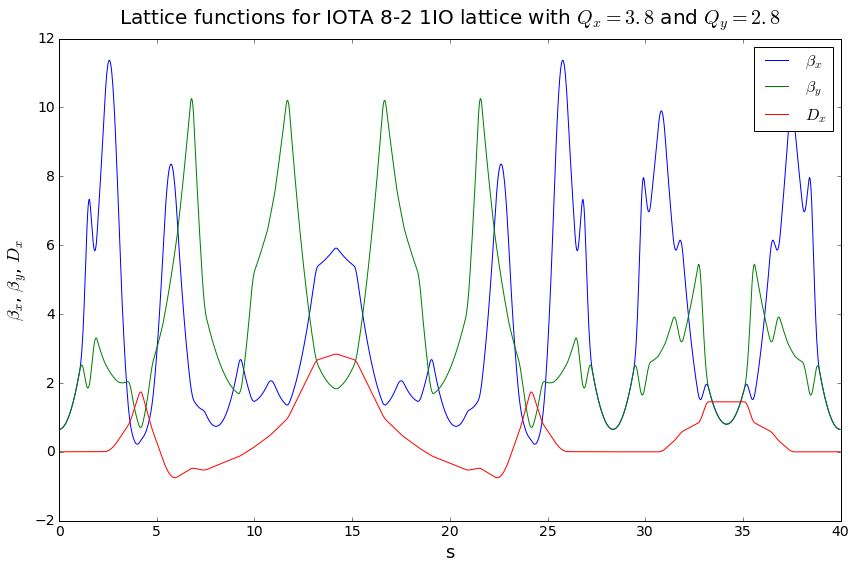

In [9]:
opts.save = False
opts.lattice_name = 'IOTA 8-2 1IO lattice with $Q_x = 3.8$ and $Q_y = 2.8$'
opts.lf_fns = ['beta_x','beta_y','D_x']
opts.lattice = lattice_dict['t1_1IO_82_lowtune']['lattice']
opts.lattice_simulator = lattice_dict['t1_1IO_82_lowtune']['lattice_simulator']
lfplot.plot_sliced_lattice_functions(opts)

## Set the lattice and generate bunch, etc.

We want to run without the nonlinear element here, so we should choose the correct lattice!

In [11]:
opts.lattice = lattice_dict['t1_1IO_82_lowtune']['lattice']
opts.lattice_simulator = lattice_dict['t1_1IO_82_lowtune']['lattice_simulator']
opts.stepper = lattice_dict['t1_1IO_82_lowtune']['stepper']
opts.lattice_name = 'Lower Tune IOTA 8-2' #For plotting

In [12]:
#======================= Now setup the bunch and other related options =====================
tval = 0.1
cval = 0.01
opts.t = tval
opts.c = cval
opts.new_tune = 0.3
opts.lnll = 1.8
opts.nseg = 20
vals = basic_calcs.get_base_nll(opts.lnll, opts.new_tune, opts.t, opts.c)
#specify vals for center of the section
opts.betae = vals[3]
opts.alphae = 0 #fixed 0 alpha for center
opts.beta0 = vals[3]

n_macro = 201
opts.dpops = (np.arange(0,n_macro)-100)*0.01*0.01 #values from -1% to 1% energy spread, seperated by 0.01% -> 201 total values
opts.macro_particles = len(opts.dpops)
bunch_length = opts.lattice.get_length() #effective bunch length is iota lattice length

#specify coordinates
bunch = np.zeros((opts.macro_particles,7))
bunch[:,0] = np.zeros(opts.macro_particles) 
bunch[:,2] = np.zeros(opts.macro_particles)
bunch[:,4] = bunch_length*(np.random.random(len(bunch)) -0.5) #center at 0
bunch[:,5] = opts.dpops
bunch[:,6] = np.asarray(range(opts.macro_particles))

bunch_name = '82_2ndOrder_LowTune_Espread_mixed_small.txt'
np.savetxt(bunch_name,bunch)         #write the bunch to a text file

bucket_length = bunch_length
particles_file = bunch_name
myBunch = read_bunch.read_bunch(particles_file, reference_particle, opts.real_particles, bucket_length, comm)

Loading Synergia particles from txt file:  82_2ndOrder_LowTune_Espread_mixed_small.txt
Read  201  particles


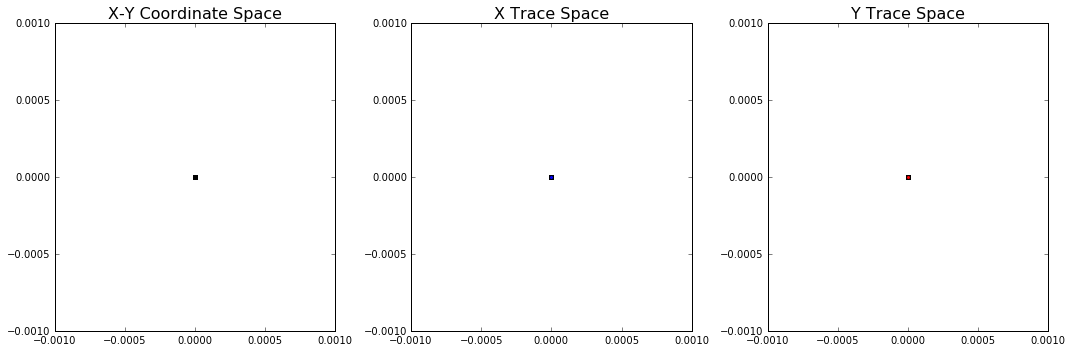

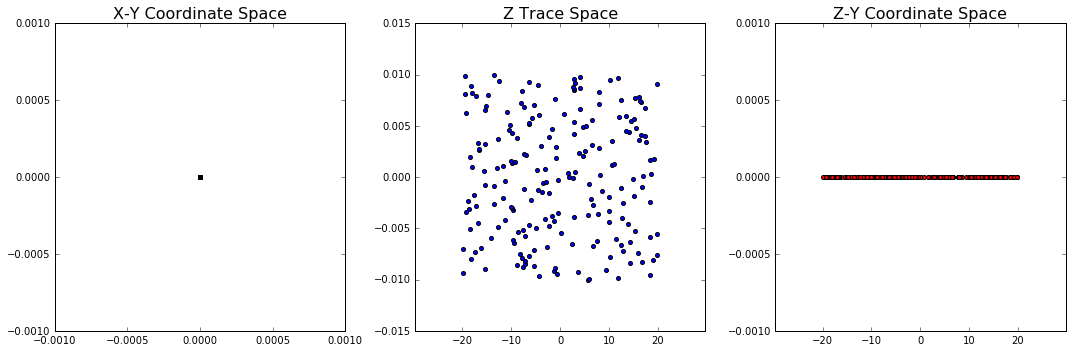

In [15]:
pltbunch.plot_bunch(myBunch)
pltbunch.plot_long(myBunch)

In [17]:
bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
bunch_simulator.add_per_turn(fulldiag)

#add forced particle diagnostics
bunch_simulator.add_per_forced_diagnostics_step(synergia.bunch.Diagnostics_particles("forced_part.h5",0,0, opts.output_dir))

#particle diagnostics - PER TURN
opts.turnsPerDiag = 1
particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
bunch_simulator.add_per_turn(particlediag, opts.turnsPerDiag)

In [18]:
opts.turns = 1024
opts.checkpointperiod = 20
opts.maxturns = opts.turns+1

propagator = synergia.simulation.Propagator(opts.stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator,opts.turns, opts.maxturns,opts.verbosity)

workflow.cleanup(opts.output_dir)

## Analysis - Compute the tune for each particle, correlate with initial energy deviation

First we note that the particles show clear evidence of nonlinear dispersion $D(\delta)$ as well as a nonzero derivative $D'(\alpha).$ We can see this by demonstrating the variation in both position and momentum with energy spread over the first few hundred turns of the simulation.

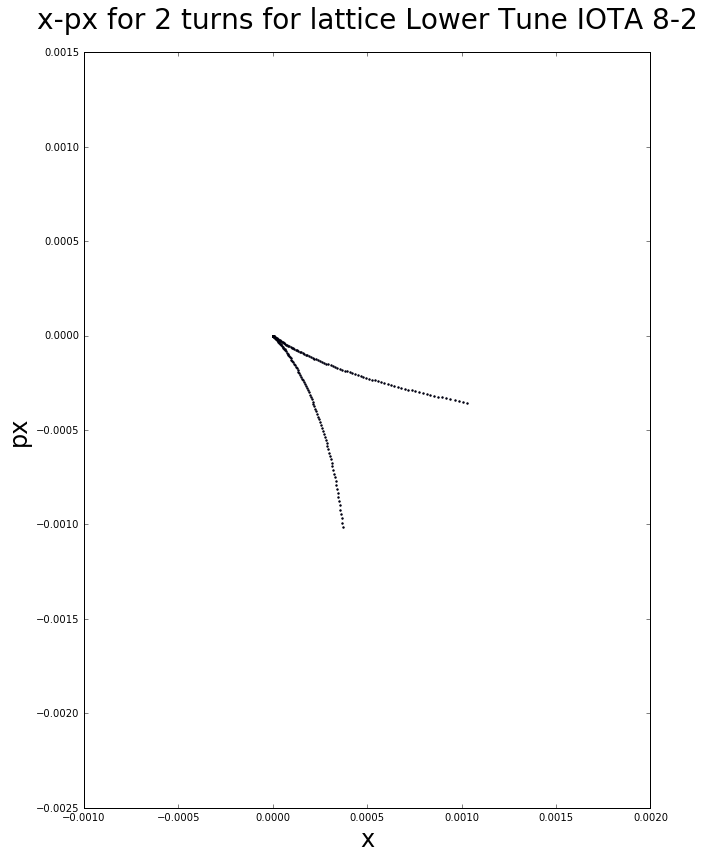

In [148]:
opts.lost = None
opts.plots = ['x','px']
opts.hcoord = opts.plots[0]
opts.vcoord = opts.plots[1]
opts.scale = 2
opts.num = 200
opts.num
opts.plot_lost = False
opts.save = False
opts.turns = 2
elliptic_sp.toy_plot_Poincare(opts)

Next we look at Poincare sections and again identify the drift in the centroid of particle trajectories with increasing energy spread. This is another indicator of nonlinear dispersion that has yet to be compensated for when changing to normalized coordinates for the phase space plot.

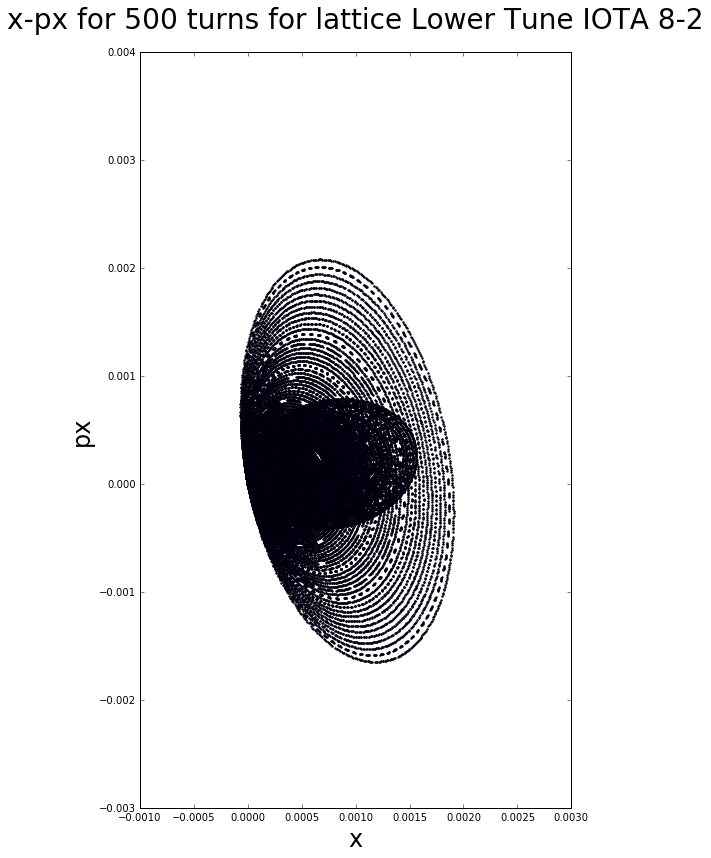

In [151]:
opts.lost = None
opts.plots = ['x','px']
opts.hcoord = opts.plots[0]
opts.vcoord = opts.plots[1]
opts.scale = 2
opts.num = 200
opts.plot_lost = False
opts.save = False
opts.turns = 500
elliptic_sp.toy_plot_Poincare(opts)

The behavior in y-py phase space is ideal, as expected, with the particles remaining at the origin over the course of the simulation.

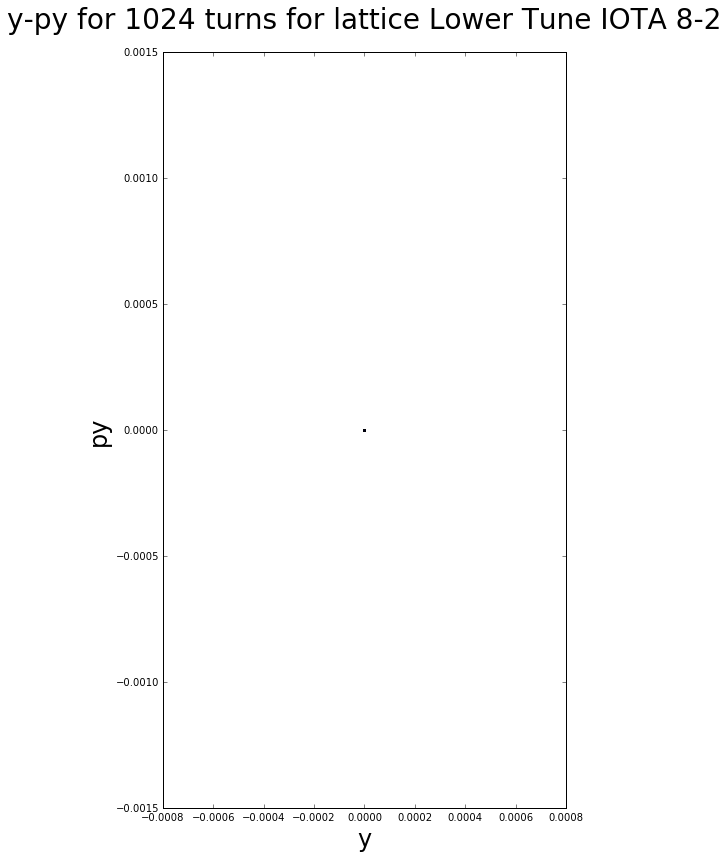

In [136]:
opts.lost = None
opts.plots = ['y','py']
opts.hcoord = opts.plots[0]
opts.vcoord = opts.plots[1]
opts.scale = 2
opts.num = 50
opts.plot_lost = False
opts.save = False
elliptic_sp.toy_plot_Poincare(opts)

### Fit the particle amplitudes to energy spread

For this exercise, we will grab the normalized coordinates (x,px) after 1 turn and plot them as a function of dp/p. This will provide us with an understanding of the scaling of the nonlinear component of the dispersion, although it will not provide us with all of the information for computing $D$ and $D'$ completely.

In [33]:
num_t = 2 #2 turns

files = elliptic_sp.get_file_list(opts)
files_cut = files[:num_t] #just grab first turn values
twiss = elliptic_sp.get_sliced_twiss(lattice_dict['t1_1IO_82_lowtune']['lattice_simulator'])

header= {}
header['s_val'] = 0.
IDlist = np.arange(len(opts.dpops))
dpop_list = 
part_array = []

for index,inputfile in enumerate(files_cut):
    #get all of the particles specifed by IDlist
    p_A = elliptic_sp.get_some_particles(inputfile,IDlist)
    norm_coords = elliptic_sp.normalized_coordinates(header, p_A, twiss)
    if len(part_array) == 0:
        #if empty, then replace with norm_coords - first turn
        part_array = norm_coords
    else:
        part_array = np.vstack((part_array,norm_coords))
        
#reshape array to be indexable by ID number     
new_PA = part_array.reshape(num_t,len(IDlist),4)

dpop_list = myBunch.get_local_particles()[:,5] #put dpop in one list
new_x = new_PA[1][:,0] #new x-values after 1 turn

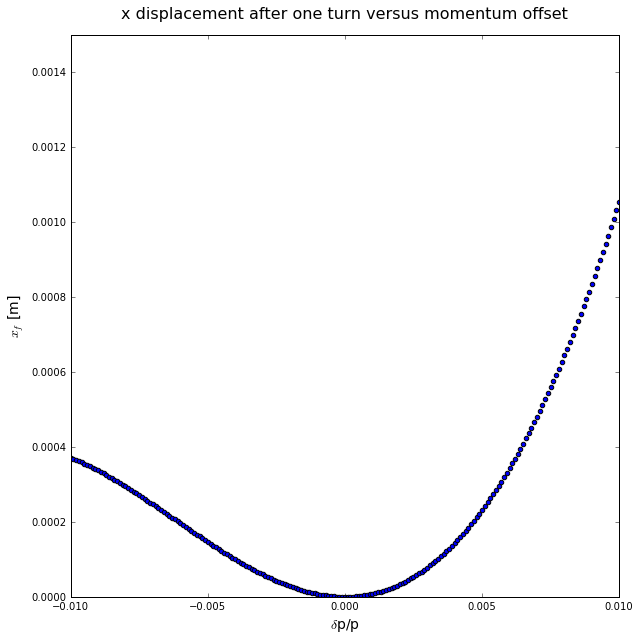

In [55]:
fig = plt.figure(figsize=(9,9))
ax = fig.gca()

ax.scatter(dpop_list,new_x)
ax.set_xlim([-0.01,0.01])
ax.set_ylim([0,0.0015])
ax.set_xlabel('$\delta$p/p', fontsize=14)
ax.set_ylabel('$x_f$ [m]', fontsize=14)
ax.set_title('x displacement after one turn versus momentum offset',fontsize=16, y=1.02)
ax.legend(scatterpoints=1, loc=2)

In [56]:
from scipy.optimize import curve_fit

def poly1(x, a, b):
    '''1st order polynomial for fitting'''
    return a * x + b

def poly2(x, a, b, c):
    '''2nd order polynomial for fitting'''
    return a * x + b*x**2 + c

def poly3(x, a, b, c, d):
    '''Third order polynomial for fitting'''
    return a * x + b*x**2 + c*x**3 + d

def poly4(x, a, b, c, d,e):
    '''Fourth order polynomial for fitting'''
    return a * x + b*x**2 + c*x**3 + d*x**4 + e

def poly5(x, a, b, c, d, e, f):
    '''Fifth order polynomial for fitting'''
    return a * x + b*x**2 + c*x**3 + d*x**4 + e*x**5 + f

def poly7(x, a, b, c, d, e, f, g, h):
    '''Seventh order polynomial for fitting'''
    return a * x + b*x**2 + c*x**3 + d*x**4 + e*x**5 + f*x**6 + g*x**7 + h

In [108]:
#poptx, pcovx = curve_fit(poly1, dpop_list,new_x)
#print "First Order Fit for x-amplitude"
#for ind,val in enumerate(poptx1[:-1]):
#    print "Order {} term in fit: {}".format(ind+1,val)
  

st2 = 50
en2 = 151
poptx2, pcovx2 = curve_fit(poly2, dpop_list[st2:en2], new_x[st2:en2])
print "Second Order Partial Fit for dispersion"
for ind,val in enumerate(poptx2[:-1]):
    print "Order {} term in fit: {}".format(ind+1,val)    
    
print ""
poptx3, pcovx3 = curve_fit(poly3, dpop_list[st2:en2], new_x[st2:en2])
print "Third Order Full Fit for dispersion"
for ind,val in enumerate(poptx3[:-1]):
    print "Order {} term in fit: {}".format(ind+1,val)
    
print ""
poptx4, pcovx4 = curve_fit(poly4, dpop_list[50:151], new_x[50:151])
print "Fourth Order Partial Fit for dispersion"
for ind,val in enumerate(poptx4[:-1]):
    print "Order {} term in fit: {}".format(ind+1,val)

Second Order Partial Fit for dispersion
Order 1 term in fit: 0.00520134470365
Order 2 term in fit: 7.57251990906

Third Order Full Fit for dispersion
Order 1 term in fit: -7.77978492217e-06
Order 2 term in fit: 7.57251997264
Order 3 term in fit: 340.510167328

Fourth Order Partial Fit for dispersion
Order 1 term in fit: -7.77958468344e-06
Order 2 term in fit: 7.69719492848
Order 3 term in fit: 340.510148418
Order 4 term in fit: -5705.95528838


We can identify the effective weighting of each order in the fit by looking at some larger values of dp/p and evaluating their amplitudes relative to the lower order terms. In this case we find that while the 2nd order term clearly dominates, there is a signifcant 3rd order contribution at large momentum offsets.

In [143]:
order4 = poptx4[-2]*dpop_list[0]**4
order3 = poptx3[-2]*dpop_list[0]**3
order2 = poptx2[-2]*dpop_list[0]**2

print "Ratio of 3rd order to 2nd order contributions to fit is {}".format(order3/order2)
print "Ratio of 4th order to 2nd order contributions to fit is {}".format(order4/order2)

Ratio of 3rd order to 2nd order contributions to fit is -0.449665595359
Ratio of 4th order to 2nd order contributions to fit is -0.0753508126343


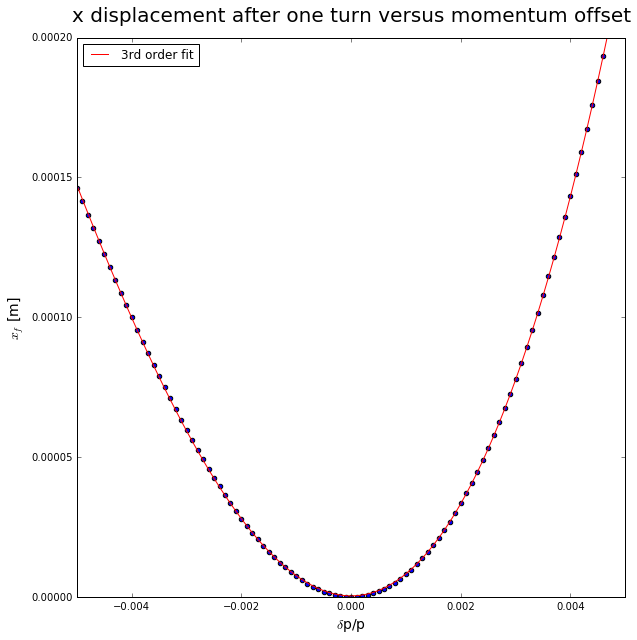

In [157]:
st=50
en=151
p_poly2x = poly2(dpop_list[st:en], poptx2[0],poptx2[1],poptx2[2])
poly3x = poly3(dpop_list[st:en], poptx3[0],poptx3[1],poptx3[2],poptx3[3])
p_poly4x = poly4(dpop_list[st:en], poptx4[0],poptx4[1],poptx4[2],poptx4[3], poptx4[4])

fig = plt.figure(figsize=(9,9))
ax = fig.gca()

ax.scatter(dpop_list[st:en],new_x[st:en])
#ax.plot(dpop_list[st:en],p_poly2x,'b', label = '2th order partial')
ax.plot(dpop_list[st:en],poly3x,'r', label = '3rd order fit')
#ax.plot(dpop_list[st:en],p_poly4x,'g', label = '4th order partial')
ax.set_xlim([-0.005,0.005])
ax.set_ylim([0,0.0002])
ax.set_xlabel('$\delta$p/p', fontsize=14)
ax.set_ylabel('$x_f$ [m]', fontsize=14)
ax.set_title('x displacement after one turn versus momentum offset',fontsize=20, y=1.02)
ax.legend(scatterpoints=1, loc=2)

plt.savefig('3rd_order_dispersion_fit.png', bbox_inches='tight')
plt.show()

### Plot Courant Synder Invariant to illustrate the need for re-normalization due to dispersion

As expected, our incomplete normalization does not provide coordinates for which the Courant Syner Invariant can be calculated via the standard $p^2 + q^2$ form. We can see this by plotting the computed invariant for particles with different energy offsets over many turns and observing the scale of the variation (which increases as dp/p is increased).

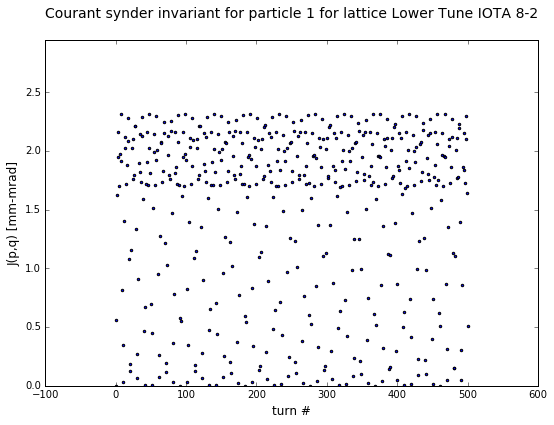

In [174]:
opts.lost = None
opts.plots = ['y','py']
opts.hcoord = opts.plots[0]
opts.vcoord = opts.plots[1]
opts.scale = 2
opts.norm = False
opts.variance = 1.
opts.ID = 1
opts.num = 50
opts.plot_lost = False
opts.save = False
elliptic_sp.plot_invariant(opts)